In [15]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'asl-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F177084%2F399170%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T072030Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1e0acba25c16e841e0170164f490e6d51d7d7c990a3d5d877464aa4ec61b8d8cbcfbe4be51d8aa299fe23827ef65bf2ef8c7e608e295f417a323a100a0e8ee32605d808cd0a9f2f68e98058925de56fd4e95cf741f8a4ba7f1da8a51bfa73329082eafc4bdfd0aa9b926630a370a2b21e09a55eef5e324d0d3e9ffea67f3714cda5012f0ed683ce30ae302c98cf68b20d9d84ef6e2cc443e0b61f36bc9f59c5ef5179dcb6febac26745906849c0e9f1f3825e83dfc60255d21d1077139c1a3fa9e8ed22128365fe277887a1763e9d8770c4c774bc0aa8e26632a54b3f0c56197e53a334e304c462feb2d662fbf26b69248a9583c4e207ee53c74edd2be7dc208'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 59642568 bytes downloaded
Downloaded and uncompressed: asl-dataset
Data source import complete.


In [16]:
import io
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [17]:
#Copying current content to new editable directory

!cp -r "../input/asl-dataset/asl_dataset/" "/kaggle/working/"

#Selecting dataset directory

ds_asl_dir = "/kaggle/working/asl_dataset/asl_dataset"

#Generating a dataset

asl_ds = tf.keras.preprocessing.image_dataset_from_directory(ds_asl_dir)

Found 2515 files belonging to 36 classes.


In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

#Listing directory. You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

!ls "/kaggle/working/asl_dataset/asl_dataset"

#Showing index + class

pd.DataFrame(asl_ds.class_names)

0  2  4  6  8  a  c  e	g  i  k  m  o  q  s  u	w  y
1  3  5  7  9  b  d  f	h  j  l  n  p  r  t  v	x  z


In [19]:
#Checking images and labels shapes (amount of images, height, width, color channels)

for image_batch, labels_batch in asl_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [20]:
#Displaying some picture´s size

from PIL import Image
img =  Image.open("/kaggle/working/asl_dataset/asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg")
width, height = img.size
print(f"Image sample with width={width} and height={height}.")

Image sample with width=400 and height=400.


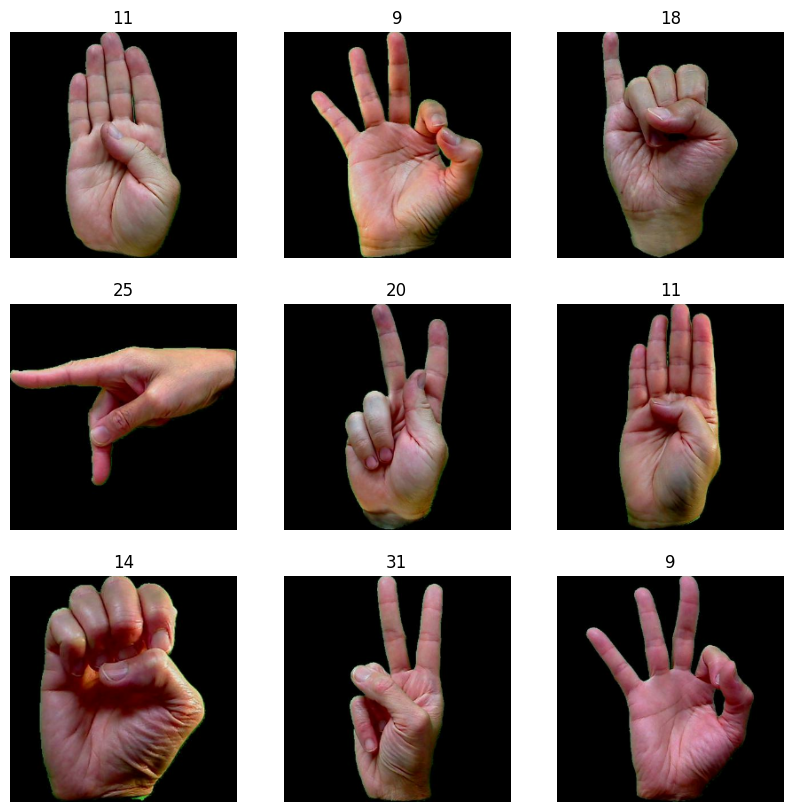

In [21]:
#Displaying image samples

plt.figure(figsize=(10, 10))
for images, labels in asl_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [22]:
#Defining parameters for the loader

batch_size = 32
img_height = 64
img_width = 64

#Filtering out corrupted images

import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(ds_asl_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

#Augmenting the images

from keras.preprocessing.image import ImageDataGenerator
data_augmentation = ImageDataGenerator(rotation_range=15, rescale=1/255, zoom_range=0.1, horizontal_flip=True,
                                       width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2)

#Setting train/test split

asl_train_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                     class_mode="categorical", batch_size=batch_size, subset="training")
asl_test_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                    class_mode="categorical", batch_size=batch_size, subset="validation")

Deleted 0 images
Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


In [23]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense

#Checking if the data format i.e the RGB channel is coming first or last so, whatever it may be, model will check first and then input shape will be feeded accordingly.

from keras import backend as K
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

#Creating a model

model_dl = keras.Sequential()
model_dl.add(Conv2D(16,(3,3),activation="relu",input_shape=(input_shape)))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(32,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(64,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Flatten())
model_dl.add(Dense(128,activation="relu"))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(36,activation="softmax"))

In [24]:
#Compiling the neural network

model_dl.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Fitting to the model

from keras.callbacks import EarlyStopping,ReduceLROnPlateau #Import callback functions
earlystop=EarlyStopping(patience=10) #Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_acc",min_lr=0.001) #Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

model_dl.fit(asl_train_ds, validation_data=asl_test_ds, callbacks=callbacks, epochs=50)

Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 3.5291 - accuracy: 0.0477

63/63 [==============================] - 17s 241ms/step - loss: 3.5291 - accuracy: 0.0477 - val_loss: 3.2712 - val_accuracy: 0.1511 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 2.9377 - accuracy: 0.1402

63/63 [==============================] - 14s 227ms/step - loss: 2.9377 - accuracy: 0.1402 - val_loss: 2.4643 - val_accuracy: 0.2565 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 2.4508 - accuracy: 0.2391

63/63 [==============================] - 13s 211ms/step - loss: 2.4508 - accuracy: 0.2391 - val_loss: 1.9802 - val_accuracy: 0.3976 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - ETA: 0s - loss: 2.0281 - accuracy: 0.3608

63/63 [==============================] - 14s 225ms/step - loss: 2.0281 - accuracy: 0.3608 - val_loss: 1.6765 - val_accuracy: 0.4851 - lr: 0.0010
Epoch 5/50
63/63 [==============================] - ETA: 0s - loss: 1.7775 - accuracy: 0.4145

63/63 [==============================] - 13s 209ms/step - loss: 1.7775 - accuracy: 0.4145 - val_loss: 1.4164 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 6/50
63/63 [==============================] - ETA: 0s - loss: 1.6150 - accuracy: 0.4518

63/63 [==============================] - 13s 203ms/step - loss: 1.6150 - accuracy: 0.4518 - val_loss: 1.2116 - val_accuracy: 0.6183 - lr: 0.0010
Epoch 7/50
63/63 [==============================] - ETA: 0s - loss: 1.4363 - accuracy: 0.5055

63/63 [==============================] - 14s 228ms/step - loss: 1.4363 - accuracy: 0.5055 - val_loss: 1.1315 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 8/50
63/63 [==============================] - ETA: 0s - loss: 1.3417 - accuracy: 0.5293

63/63 [==============================] - 14s 221ms/step - loss: 1.3417 - accuracy: 0.5293 - val_loss: 1.0224 - val_accuracy: 0.6740 - lr: 0.0010
Epoch 9/50
63/63 [==============================] - ETA: 0s - loss: 1.2147 - accuracy: 0.5731

63/63 [==============================] - 13s 202ms/step - loss: 1.2147 - accuracy: 0.5731 - val_loss: 1.0121 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 10/50
63/63 [==============================] - ETA: 0s - loss: 1.1450 - accuracy: 0.6024

63/63 [==============================] - 14s 226ms/step - loss: 1.1450 - accuracy: 0.6024 - val_loss: 0.9697 - val_accuracy: 0.6660 - lr: 0.0010
Epoch 11/50
63/63 [==============================] - ETA: 0s - loss: 1.0563 - accuracy: 0.6228

63/63 [==============================] - 13s 203ms/step - loss: 1.0563 - accuracy: 0.6228 - val_loss: 0.7897 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 12/50
63/63 [==============================] - ETA: 0s - loss: 1.0036 - accuracy: 0.6387

63/63 [==============================] - 14s 219ms/step - loss: 1.0036 - accuracy: 0.6387 - val_loss: 0.8063 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 13/50
63/63 [==============================] - ETA: 0s - loss: 0.9352 - accuracy: 0.6650

63/63 [==============================] - 13s 203ms/step - loss: 0.9352 - accuracy: 0.6650 - val_loss: 0.7547 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 14/50
63/63 [==============================] - ETA: 0s - loss: 0.9219 - accuracy: 0.6740

63/63 [==============================] - 13s 204ms/step - loss: 0.9219 - accuracy: 0.6740 - val_loss: 0.6908 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 15/50
63/63 [==============================] - ETA: 0s - loss: 0.8457 - accuracy: 0.6904

63/63 [==============================] - 13s 203ms/step - loss: 0.8457 - accuracy: 0.6904 - val_loss: 0.6118 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 16/50
63/63 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.7112

63/63 [==============================] - 13s 204ms/step - loss: 0.8176 - accuracy: 0.7112 - val_loss: 0.6646 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 17/50
63/63 [==============================] - ETA: 0s - loss: 0.8459 - accuracy: 0.7003

63/63 [==============================] - 13s 203ms/step - loss: 0.8459 - accuracy: 0.7003 - val_loss: 0.6426 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 18/50
63/63 [==============================] - ETA: 0s - loss: 0.7867 - accuracy: 0.7078

63/63 [==============================] - 14s 220ms/step - loss: 0.7867 - accuracy: 0.7078 - val_loss: 0.5588 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 19/50
63/63 [==============================] - ETA: 0s - loss: 0.7707 - accuracy: 0.7122

63/63 [==============================] - 15s 242ms/step - loss: 0.7707 - accuracy: 0.7122 - val_loss: 0.5882 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 20/50
63/63 [==============================] - ETA: 0s - loss: 0.7127 - accuracy: 0.7346

63/63 [==============================] - 13s 208ms/step - loss: 0.7127 - accuracy: 0.7346 - val_loss: 0.5605 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 21/50
63/63 [==============================] - ETA: 0s - loss: 0.7391 - accuracy: 0.7291

63/63 [==============================] - 14s 218ms/step - loss: 0.7391 - accuracy: 0.7291 - val_loss: 0.6005 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 22/50
63/63 [==============================] - ETA: 0s - loss: 0.7599 - accuracy: 0.7276

63/63 [==============================] - 14s 225ms/step - loss: 0.7599 - accuracy: 0.7276 - val_loss: 0.5604 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 23/50
63/63 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.7560

63/63 [==============================] - 13s 201ms/step - loss: 0.6432 - accuracy: 0.7560 - val_loss: 0.5162 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 24/50
63/63 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.7540

63/63 [==============================] - 13s 200ms/step - loss: 0.6536 - accuracy: 0.7540 - val_loss: 0.5264 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 25/50
63/63 [==============================] - ETA: 0s - loss: 0.6112 - accuracy: 0.7664

63/63 [==============================] - 16s 246ms/step - loss: 0.6112 - accuracy: 0.7664 - val_loss: 0.5496 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 26/50
63/63 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.7763

63/63 [==============================] - 14s 219ms/step - loss: 0.5997 - accuracy: 0.7763 - val_loss: 0.4964 - val_accuracy: 0.8012 - lr: 0.0010
Epoch 27/50
63/63 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.7694

63/63 [==============================] - 13s 202ms/step - loss: 0.6405 - accuracy: 0.7694 - val_loss: 0.4695 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 28/50
63/63 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.7694

63/63 [==============================] - 14s 211ms/step - loss: 0.6070 - accuracy: 0.7694 - val_loss: 0.4738 - val_accuracy: 0.8270 - lr: 0.0010
Epoch 29/50
63/63 [==============================] - ETA: 0s - loss: 0.5826 - accuracy: 0.7813

63/63 [==============================] - 13s 204ms/step - loss: 0.5826 - accuracy: 0.7813 - val_loss: 0.4384 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 30/50
63/63 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.7883

63/63 [==============================] - 14s 220ms/step - loss: 0.5542 - accuracy: 0.7883 - val_loss: 0.4637 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 31/50
63/63 [==============================] - ETA: 0s - loss: 0.5398 - accuracy: 0.7997

63/63 [==============================] - 13s 206ms/step - loss: 0.5398 - accuracy: 0.7997 - val_loss: 0.4127 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 32/50
63/63 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.8022

63/63 [==============================] - 13s 202ms/step - loss: 0.5420 - accuracy: 0.8022 - val_loss: 0.5100 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 33/50
63/63 [==============================] - ETA: 0s - loss: 0.5284 - accuracy: 0.7982

63/63 [==============================] - 13s 201ms/step - loss: 0.5284 - accuracy: 0.7982 - val_loss: 0.4091 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 34/50
63/63 [==============================] - ETA: 0s - loss: 0.5461 - accuracy: 0.7908

63/63 [==============================] - 13s 202ms/step - loss: 0.5461 - accuracy: 0.7908 - val_loss: 0.4404 - val_accuracy: 0.8231 - lr: 0.0010
Epoch 35/50
63/63 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.7942

63/63 [==============================] - 14s 220ms/step - loss: 0.5477 - accuracy: 0.7942 - val_loss: 0.4454 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 36/50
63/63 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.8082

63/63 [==============================] - 14s 221ms/step - loss: 0.5226 - accuracy: 0.8082 - val_loss: 0.4796 - val_accuracy: 0.8032 - lr: 0.0010
Epoch 37/50
63/63 [==============================] - ETA: 0s - loss: 0.5018 - accuracy: 0.8265

63/63 [==============================] - 13s 205ms/step - loss: 0.5018 - accuracy: 0.8265 - val_loss: 0.3911 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 38/50
63/63 [==============================] - ETA: 0s - loss: 0.5266 - accuracy: 0.8116

63/63 [==============================] - 16s 259ms/step - loss: 0.5266 - accuracy: 0.8116 - val_loss: 0.4391 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 39/50
63/63 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.8156

63/63 [==============================] - 14s 221ms/step - loss: 0.4825 - accuracy: 0.8156 - val_loss: 0.4250 - val_accuracy: 0.8390 - lr: 0.0010
Epoch 40/50
63/63 [==============================] - ETA: 0s - loss: 0.5100 - accuracy: 0.8082

63/63 [==============================] - 13s 207ms/step - loss: 0.5100 - accuracy: 0.8082 - val_loss: 0.4095 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 41/50
63/63 [==============================] - ETA: 0s - loss: 0.5176 - accuracy: 0.8017

63/63 [==============================] - 14s 221ms/step - loss: 0.5176 - accuracy: 0.8017 - val_loss: 0.4289 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 42/50
63/63 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.8156

63/63 [==============================] - 13s 208ms/step - loss: 0.4747 - accuracy: 0.8156 - val_loss: 0.4206 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 43/50
63/63 [==============================] - ETA: 0s - loss: 0.4463 - accuracy: 0.8305

63/63 [==============================] - 13s 206ms/step - loss: 0.4463 - accuracy: 0.8305 - val_loss: 0.4358 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 44/50
63/63 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.8325

63/63 [==============================] - 14s 219ms/step - loss: 0.4499 - accuracy: 0.8325 - val_loss: 0.4469 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 45/50
63/63 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8285

63/63 [==============================] - 13s 205ms/step - loss: 0.4650 - accuracy: 0.8285 - val_loss: 0.3939 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 46/50
63/63 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.8146

63/63 [==============================] - 15s 241ms/step - loss: 0.4846 - accuracy: 0.8146 - val_loss: 0.4586 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 47/50
63/63 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.8176

63/63 [==============================] - 13s 205ms/step - loss: 0.4637 - accuracy: 0.8176 - val_loss: 0.4056 - val_accuracy: 0.8370 - lr: 0.0010


In [25]:
#Saving the model

model_dl.save("model_dl.h5")

#Loading themodel

model_dl = keras.models.load_model("model_dl.h5") #look for local saved file